# Laplacian of Gaussian
---

In [12]:
from skimage.segmentation import watershed
watershed?

Signature:
watershed(
    image,
    markers,
    connectivity=1,
    offset=None,
    mask=None,
    compactness=0,
    watershed_line=False,
)
Docstring:
Find watershed basins in `image` flooded from given `markers`.

Parameters
----------
image: ndarray (2-D, 3-D, ...) of integers
    Data array where the lowest value points are labeled first.
markers: int, or ndarray of int, same shape as `image`
    The desired number of markers, or an array marking the basins with the
    values to be assigned in the label matrix. Zero means not a marker.
connectivity: ndarray, optional
    An array with the same number of dimensions as `image` whose
    non-zero elements indicate neighbors for connection.
    Following the scipy convention, default is a one-connected array of
    the dimension of the image.
offset: array_like of shape image.ndim, optional
    offset of the connectivity (one offset per dimension)
mask: ndarray of bools or 0s and 1s, optional
    Array of same shape as `image`. On

In [58]:
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from shapely.geometry import polygon, box

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.set_cmap('magma'); plt.close()

from skimage.measure import regionprops
from skimage.feature import canny
from skimage.filters import threshold_otsu, sobel
from skimage.measure import label
from skimage.segmentation import clear_border, felzenszwalb
from skimage.color import hed_from_rgb, grey2rgb, label2rgb

import secdetect

## Process overview image
---

In [100]:
# Load random overview image from `secdetect.data`
imin = secdetect.data.load(12)
imec = secdetect.enhance_contrast(imin, channel=2, conv_matrix=hed_from_rgb)
imcn = canny(imec, sigma=4, low_threshold=0.10, high_threshold=0.99, use_quantiles=True)
cx, cy, r = secdetect.find_ring(imcn)
imcr = secdetect.crop_to_ring(imin, cx=cx, cy=cy, radius=r)
imeccr = secdetect.crop_to_ring(imec, cx=cx, cy=cy, radius=r)

# Mask with Felzenszwalb segmentation
imfz = felzenszwalb(imcr, scale=750, sigma=1, min_size=500, multichannel=True)
imcb = clear_border(imfz, buffer_size=30)
mask = imcb > 0
mask_rgb = grey2rgb(mask)

masked_grey = np.where(mask, imeccr, 0)
masked_rgb = np.where(mask_rgb, imcr, 0)

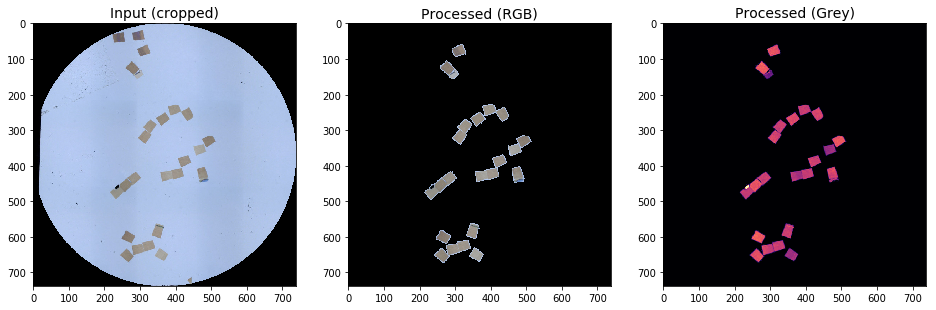

In [101]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
axes[0].imshow(imcr)
axes[1].imshow(masked_rgb)
axes[2].imshow(masked_grey)
axes[0].set_title('Input (cropped)', fontsize=14)
axes[1].set_title('Processed (RGB)', fontsize=14)
axes[2].set_title('Processed (Grey)', fontsize=14);

## Iterate through parameter space
---

In [102]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in product(*vals):
        yield dict(zip(keys, instance))

In [107]:
watershed_param_set = {
    'connectivity': [1],
    'compactness': [0, 1, 10, 100],
    'watershed_line': [True, False]
}

watershed_param_space = list(product_dict(**watershed_param_set))

print(f'{len(watershed_param_space)} permutations')

8 permutations


In [108]:
columns = list(watershed_param_set.keys())
df = pd.DataFrame(columns=columns)

i = 0
segments = []
for watershed_params in tqdm_notebook(watershed_param_space):
    
    # Make segmentation using edge-detection and watershed.
    edges = sobel(masked_grey)
    markers = np.zeros_like(masked_grey)
    fg, bg = 1, 2
    thresh = threshold_otsu(masked_grey)
    markers[masked_grey < thresh] = bg
    markers[masked_grey > thresh] = fg
    
    # Run watershedding
    ws = watershed(edges, markers, **watershed_params)
    labels = label(ws == fg)
    segments.append(labels)
    
    # Build up DataFrame
    df = df.append(pd.DataFrame(watershed_params, index=[i]), sort=True)
    
    # Increment index
    i += 1

# Preview DataFrame
var_cols = [k for k, v in watershed_param_set.items() if len(v) > 1]
df[var_cols].sample(3)

,compactness,watershed_line
0,0,True
2,1,True
6,100,True


## Analysis
---

In [109]:
# Make new cmap for label images
base_colors = ['#000000',  # black
               '#ff99aa',  # pink
               '#ffcc00',  # orange
               '#ffff00',  # yellow
               '#00ff00',  # green
               '#00ddff']  # cyan
weights = [0] + np.linspace(0, 1, len(base_colors)-1).tolist()
weighted_colors = list(zip(weights, base_colors))
neon = LinearSegmentedColormap.from_list("", weighted_colors)

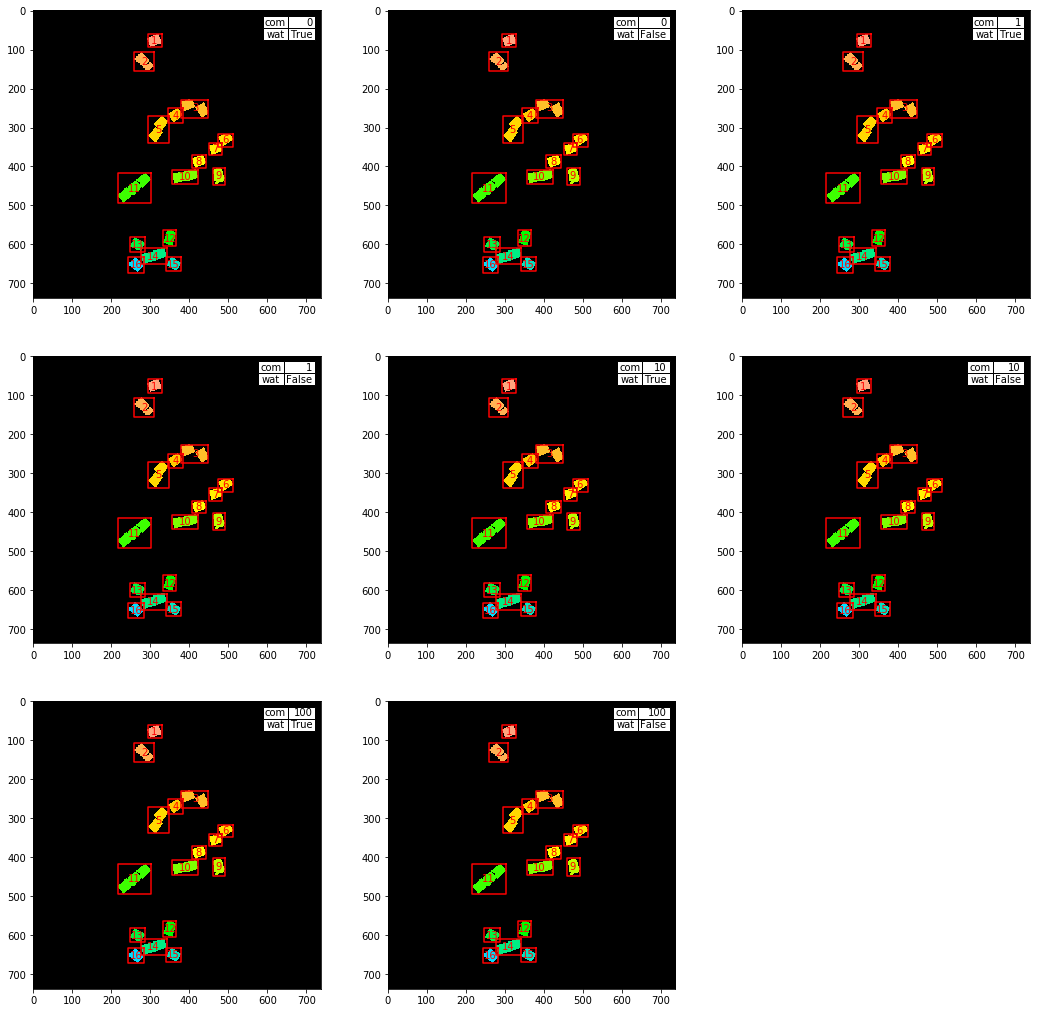

In [110]:
ncols = 3
nrows = int(np.ceil(len(df) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
axes = axes.ravel()

for i, row in df.iterrows():
    
    # Plot image
    labels = segments[i]
    axes[i].imshow(labels, cmap=neon)
    
    # Plot bounding boxes
    for j, region in enumerate(regionprops(labels)):
        y0, x0, y1, x1 = region.bbox
        p = box(x0, y0, x1, y1)
        # Annotate sections
        axes[i].plot(*p.exterior.xy, color='#ff0000', lw=1.5)
        axes[i].text(x=region.centroid[1], y=region.centroid[0], s=j+1,
                     color='#ff0000', ha='center', va='center')
    
    # Make table
    vals = row[var_cols].values[:, np.newaxis]
    cols = [col[:3] for col in row[var_cols].index.tolist()]
    tab = axes[i].table(cellText=vals, rowLabels=cols,
                        rowLoc='center', loc='upper right',
                        zorder=1)
    tab.auto_set_column_width(0)

# Remove empty axes from fig
num = axes.size - len(df)  # num of empty axes
[fig.delaxes(ax) for ax in axes[-num:] if num > 0];